In [ ]:
!pip install poetry
!pip install ray
!pip install tensorboardX

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/DL project'
import sys
sys.path.append(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New section

In [ ]:
modelName = 'convlstm'
import datetime
import getpass
import json
import os
import pathlib
from shutil import copyfile
import torch
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from config_convlstm import code_path, data_path, figure_path, model_path
from src.data import DataframeDataLoader
from src.evaluation_convlstm import evaluateModel
from src.load_data import dataLoader
from src.models.convlstm import DilatedNet
from src.parameter_sets.par import *
from src.tools_convlstm import train_cgm


from optimizeHypers_convlstm import searchBestHypers, test_rmse
from pathlib import Path

In [ ]:
# %load_ext autoreload
# %autoreload 2

# Paths to data, code, figures, etc. should be set in config.py.
# Initialize the config.py file by copying from config.template.py.
# ---------------------------------------------------------------------
# DEFINE MODEL, PARAMETERS AND DATA
# - Change <par> to the name of file containing your parameters
# - Change <hediaNet> to the name of file containing your model architecture and DilatedNet to the name
#   of your model. Also change in train_cgm and optmizeHypers.py
# ---------------------------------------------------------------------


# Tensorboard log setup
# Create a directory for the model if it doesn't already exist
current_time = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
user = getpass.getuser()
model_id = f'id_{current_time}_{user}'
model_path_id = model_path / model_id
model_path_id.mkdir(exist_ok=True, parents=True)
#pathlib.Path(model_path_id).mkdir(parents=True, exist_ok=True)
model_figure_path = figure_path / model_id
model_figure_path.mkdir(exist_ok=True, parents=True)
#pathlib.Path(model_figure_path).mkdir(parents=True, exist_ok=True)





In [ ]:

# ---------------------------------------------------------------------
# DEFINE DATA
# ---------------------------------------------------------------------
# Define data object
data_pars = {}
data_pars['path'] = data_path
data_pars['train_data'] = train_data
data_pars['test_data'] = test_data
data_pars['validation_data'] = val_data

# data_pars['train_data'] = train_data
# data_pars['test_data'] = test_data
# data_pars['validation_data'] = test_data

data_pars['start_date_train'] = start_date_train
data_pars['start_date_test'] = start_date_test
data_pars['start_date_validation'] = start_date_val

data_pars['end_date_train'] = end_date_train
data_pars['end_date_test'] = end_date_test
data_pars['end_date_validation'] = end_date_val


data_obj = dataLoader(data_pars, features, n_steps_past=16,
                      n_steps_future=6,
                      allowed_gap=10,
                      scaler=StandardScaler())


# Optimize hyper parameters

In [ ]:
import os
os.chdir('/content/drive/My Drive/DL project/')
from ray import tune

In [ ]:
#searchBestHypers(num_samples=100, max_num_epochs=30, n_epochs_stop=10, grace_period=5, gpus_per_trial=0,data_obj=data_obj)

In [ ]:
# ---------------------------------------------------------------------
# EXTRACT DATA AND TEST THE MODEL
# ---------------------------------------------------------------------

#simulate 
#config = {'batch_size': 16, 'lr': 0.00042896977136120545, 'h1': 8, 'h2': 8, 'h3': 32, 'h4': 4, 'h5': 128, 'h6': 1, 'wd': 0.0016293727272702564}
#real
config = {'batch_size': 4, 'lr': 0.0053398216651144225, 'h1': 4, 'h2': 8, 'h3': 64, 'h4': 4, 'h5': 16, 'h6': 2, 'wd': 0.022238885638817846}


model = DilatedNet(h1=config["h1"], 
                   h2=config["h2"],
                   h3=config["h3"],
                   h4=config["h4"],
                   h5=config["h5"],
                   h6=config["h6"]) 
                   

# Load training data
trainset, valset = data_obj.load_train_and_val()

train_loader = DataframeDataLoader(
    trainset,
    batch_size=int(config['batch_size']),
    shuffle=True,
    drop_last=True,
)

# Perform a single prediction
data = next(iter(train_loader))

inputs, targets = data
# It is important to permute the dimensions of the input!!
inputs = Variable(inputs.permute(0, 2, 1)).contiguous()

output= model(inputs)

DilatedNet(
  (relu): ReLU()
  (max_pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(4, 4, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv2): Conv1d(4, 8, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv3): Conv1d(8, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  (lstm): LSTM(64, 4, num_layers=2, bidirectional=True)
  (lin1): Linear(in_features=128, out_features=16, bias=False)
  (lin2): Linear(in_features=16, out_features=1, bias=False)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
# ---------------------------------------------------------------------
# TRAING THE MODEL
# ---------------------------------------------------------------------
# Make sure the model archiecture loaded in train_cgm matches the hyper configuration
train_cgm(config, max_epochs=50, grace_period=5,
          n_epochs_stop=15, data_obj=data_obj, useRayTune=False) #checkpoint_dir = '/content/drive/MyDrive/DL project/HediaLSTM_Mikkel/02456_deeplearning_cgmforecast/src/model_state_tmp/' )

# Load best model
model_state, optimizer_state = torch.load(code_path / 'src' / 'model_state_tmp' / 'checkpoint')
model.load_state_dict(model_state)

# Copy the trained model to model path
copyfile(code_path / 'src' / 'model_state_tmp' / 'checkpoint',
         model_path_id / 'checkpoint')

with open(code_path / 'src' / 'model_state_tmp' / 'hyperPars.json', 'w') as fp:
    json.dump(config, fp)


Saved better model!
Epoch 1, Training loss: 5.92E+02, Validation loss: 1.74E+03
Saved better model!
Epoch 2, Training loss: 4.81E+02, Validation loss: 1.70E+03
Saved better model!
Epoch 3, Training loss: 4.63E+02, Validation loss: 1.66E+03
Epoch 4, Training loss: 4.57E+02, Validation loss: 1.66E+03
Epoch 5, Training loss: 4.53E+02, Validation loss: 1.67E+03
Epoch 6, Training loss: 4.54E+02, Validation loss: 1.76E+03
Epoch 7, Training loss: 4.48E+02, Validation loss: 1.79E+03
Epoch 8, Training loss: 4.46E+02, Validation loss: 1.72E+03
Saved better model!
Epoch 9, Training loss: 4.38E+02, Validation loss: 1.63E+03
Epoch 10, Training loss: 4.35E+02, Validation loss: 1.64E+03
Epoch 11, Training loss: 4.34E+02, Validation loss: 1.68E+03
Epoch 12, Training loss: 4.38E+02, Validation loss: 1.66E+03
Epoch 13, Training loss: 4.30E+02, Validation loss: 1.70E+03
Epoch 14, Training loss: 4.30E+02, Validation loss: 1.68E+03
Saved better model!
Epoch 15, Training loss: 4.26E+02, Validation loss: 1.6

<Figure size 1008x216 with 0 Axes>

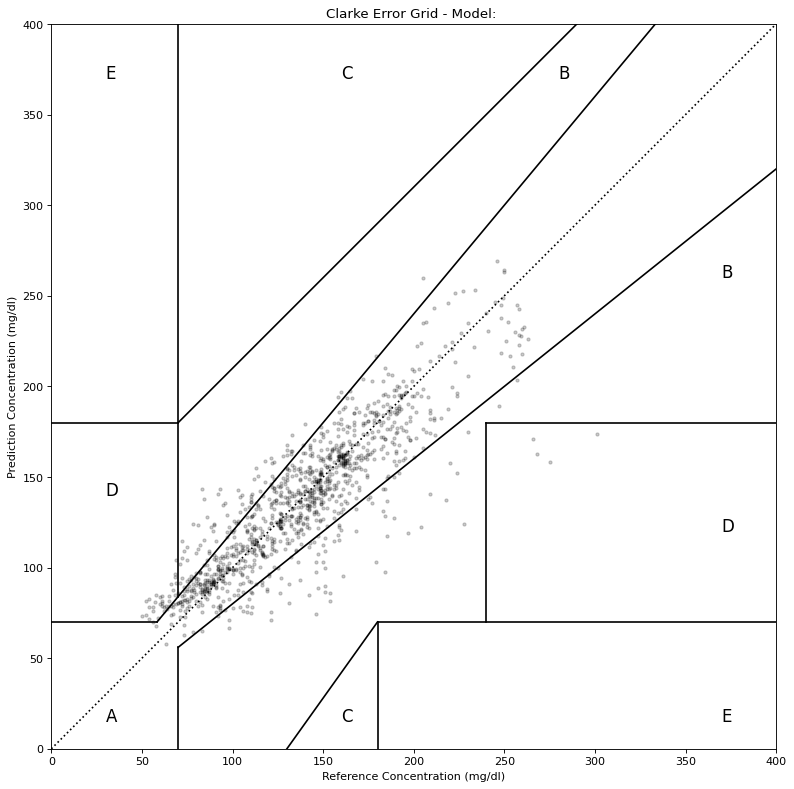

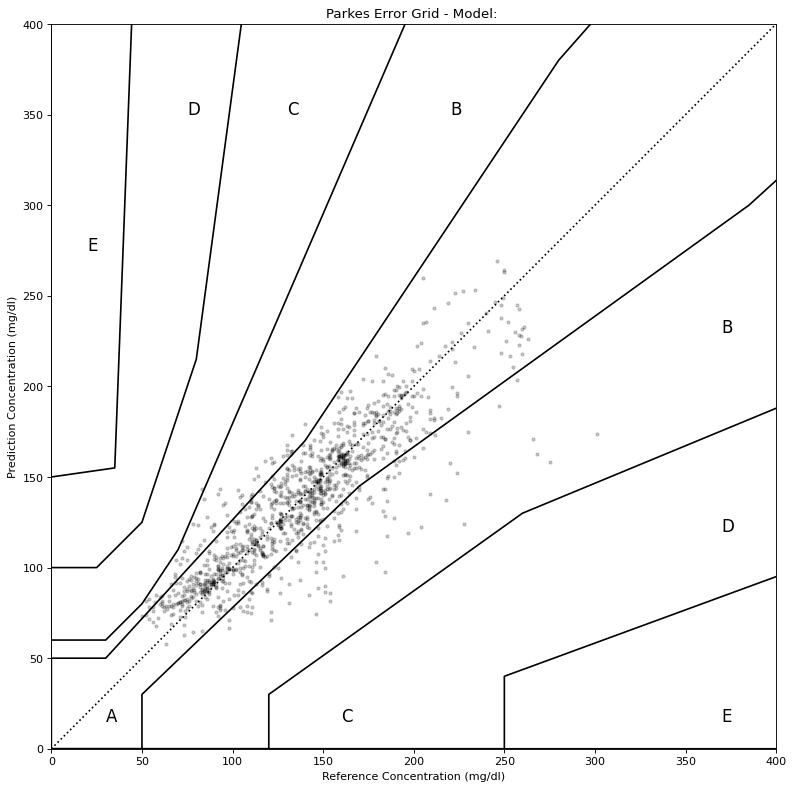

In [ ]:
# %% Evaluate model
# ---------------------------------------------------------------------
# EVALUATE THE MODEL
# ---------------------------------------------------------------------
evaluationConfiguration = {
    'distance': True,
    'hypo': True,
    'clarke': True,
    'parkes': True,
    'lag': True,
    'plotLag': True,
    'plotTimeseries': True
}
# ---------------------------------------------------------------------

evalObject = evaluateModel(data_obj, model)

import csv
if evaluationConfiguration['distance']:
    distance = evalObject.get_distanceAnalysis()
    w = csv.writer(open(model_figure_path / "distance.csv", "w"))
    for key, val in distance.items():
        w.writerow([key, val])

if evaluationConfiguration['hypo']:
    hypo = evalObject.get_hypoAnalysis()

if evaluationConfiguration['lag']:
    lag = evalObject.get_lagAnalysis(figure_path=model_figure_path)

if evaluationConfiguration['plotTimeseries']:
    evalObject.get_timeSeriesPlot(figure_path=model_figure_path)

if evaluationConfiguration['clarke']:
    clarkes, clarkes_prob = evalObject.clarkesErrorGrid(
        'mg/dl', figure_path=model_figure_path)

if evaluationConfiguration['parkes']:
    parkes, parkes_prob = evalObject.apply_parkes_error_grid(
        'mg/dl', figure_path=model_figure_path)
    


In [ ]:
    w = csv.writer(open(model_figure_path / "hypo.csv", "w"))
    for key, val in hypo.items():
        w.writerow([key, val])
